In [27]:
# install necessary packages
!pip install requests_cache
!pip install seaborn 
!pip install plot-metric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [28]:
# import standard libraries
import io
import zipfile
import requests as rq
import requests_cache as rqc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import text processing tools
import spacy
from nltk.stem import SnowballStemmer
import re

# import persistence support
from joblib import dump, load

# import support for sklearn transformers 
# and pipelines
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline

# better plot metrics 
from plot_metric.functions import BinaryClassification

In [29]:
# ensure reproducible results
rand_state = 1234

# Load Previously Trained Classifiers

We will preload the previously trained classifiers in order to ensure explainability information.

First of all we wil re-define the tokenization transformer to be used in the preloaded classifiers.

In [30]:
class TokenizationTransformer (BaseEstimator, TransformerMixin) :
  """
  Transformer that ensures processing of input text, mostly:

  * Tokenization and stemming of input text
  * Removal of superfluous information such as punctuation
    or stop words 
  """

  def __init__(self, nlp_support, custom_stop_words_tokens) :
    """
    Parameters
    ----------
      nlp_support : Object
          NLP support (usually based on Spacy)
      custom_stop_words_tokens : [str]
          A collection of custom tokens
    """
    super().__init__()
    self.nlp_support = nlp_support;
    self.covid_19_regexp = r"-19";    
    self.covid_regexp = r"covid";
    self.number_regexp = r"[0-9]+";
    self.stemmer = SnowballStemmer("english");
    self.custom_stop_words_tokens = custom_stop_words_tokens;


  def is_valid(self, token) :
    """
    Checks if a token is valid
    Parameters
    ----------
      token : str
          The token checked for validity

    Returns
    -------
    bool
        TRUE if the token is valid, otherwise FALSE          
    """
    # remove tokens based on their syntatic information 
    is_invalid = token.is_stop or \
      token.is_punct or \
      token.is_left_punct or \
      token.is_right_punct or \
      token.is_space or \
      token.is_bracket or \
      token.is_quote or \
      token.is_currency or \
      token.like_url or \
      token.like_num or \
      token.like_email;

    return not is_invalid;

  def prepare(self, text) :
    """
    Prepares a token for machine learning processing
    Parameters
    ----------
      text : str
          The token's text to be prepared, performing validation as well

    Returns
    -------
    str
        The prepared text, None if token is invalid          
    """    
    prepared_text = text.strip();  
    prepared_text = prepared_text.lower();
    prepared_text = re.sub(self.covid_19_regexp, "", prepared_text);
    prepared_text = re.sub(self.number_regexp, "", prepared_text);
    prepared_text = self.stemmer.stem(prepared_text);
    
    if (len(prepared_text) == 0) :
      return None;

    if (prepared_text in self.custom_stop_words_tokens):
      return None;  

    return prepared_text;

  def fit(self, X, Y=None) :
    return self;

  def transform(self, X, Y = None) :
    
    data_size = 0
    
    if (type(X) == np.ndarray) :
      data_size = X.shape[0]
    else:  
      data_size = len(X)

    tokens_text_processed_joined = np.repeat(None, data_size);

    for i in range(0, data_size) :
      tokens = self.nlp_support(X[i]);
      tokens_text = [];
      tokens_text_lemma = [];
      tokens_text_pos = [];
      tokens_text_processed = [];

      for token in tokens:
        if (self.is_valid(token)) :
          prepared_text = self.prepare(token.text); 
          if (prepared_text == None) :
            continue;
          tokens_text_processed = np.append(tokens_text_processed, prepared_text);

      tokens_text_processed_joined[i] = " ".join(tokens_text_processed);

    return tokens_text_processed_joined;

    def fit_transform(self, X, Y = None) :
      return self.fit(X, Y).transform(X, Y)

In [31]:
def get_remote_zip_file(archive_url, file_name) :
  """
  Retrieves an archive file from an URL and extracts the content of an inside file 
  Parameters
  ----------
    archive_url : str
        The url for retrieving the archive
    file_name : str
        The filename holding the content

  Returns
  -------
  file
      The opened file name          
  """  

  response = rqc.CachedSession().get(archive_url)
  binary_data = io.BytesIO(response.content)

  with zipfile.ZipFile(binary_data) as z:
   return z.open(file_name)


In [32]:
# load the classifier from the remote URL
MODEL_URL = "https://github.com/INTERTECHNICA-BUSINESS-SOLUTIONS-SRL/NATO-Article-COVID-Fake-News-Detection-TFIDF/raw/main/model/COVID_fake_news_TFIF_SVC_pipeline.zip"
MODEL_FILE = "COVID_fake_news_TFIF_SVC_pipeline.joblib"

loaded_classifier_pipeline = None

with get_remote_zip_file(MODEL_URL, MODEL_FILE) as f:
  loaded_classifier_pipeline = load(f)


# Load the Test Data

We will load the dataset saved along with the classifier and extract the test related data.

In [33]:
# load the classifier from the remote URL
DATASETS_URL = "https://github.com/INTERTECHNICA-BUSINESS-SOLUTIONS-SRL/NATO-Article-COVID-Fake-News-Detection-TFIDF/raw/main/data/processed/datasets.zip"
DATASETS_FILE = "datasets.npz"

X_test = None
Y_test = None

with get_remote_zip_file(DATASETS_URL, DATASETS_FILE) as f_datasets:
  loaded_data = np.load(f_datasets, allow_pickle=True)
  X_test = loaded_data["X_test"]
  Y_test = loaded_data["Y_test"]

# Identify Classifier Performance Highlights 

We will use the saved classifier for predicting if a news item is veridic or fake.

In [34]:
# predict if news are veridic or fake
# using probability predictions
Y_pred_proba = loaded_classifier_pipeline.predict_proba(X_test)

Create a binary classification object for handling model performance reporting.

In [35]:
# create binary classification object
bc = BinaryClassification(
    Y_test, 
    Y_pred_proba[:,1], 
    labels=["Veridical News", "Fake News"],
    seaborn_style= "whitegrid"
  )

Classification report presents a good performance of the classification pipeline. 

Both precision and recall and a f1 score are all close to 0.90. For a baseline syntactic classifier this is a very good score.

In [36]:
# print the generic classification report
bc.print_report()

                   ________________________
                  |  Classification Report |
                   ‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
                precision    recall  f1-score   support

Veridical News       0.90      0.92      0.91       328
     Fake News       0.92      0.90      0.91       329

      accuracy                           0.91       657
     macro avg       0.91      0.91      0.91       657
  weighted avg       0.91      0.91      0.91       657



We are interested in the data regarding the confusion matrix of the classifier. We can observe that 92% of the Veridic News have been correctly classified, while 90% of the Fake News are correctly classified as well. 

This is again very good for a model not using deep learning. 

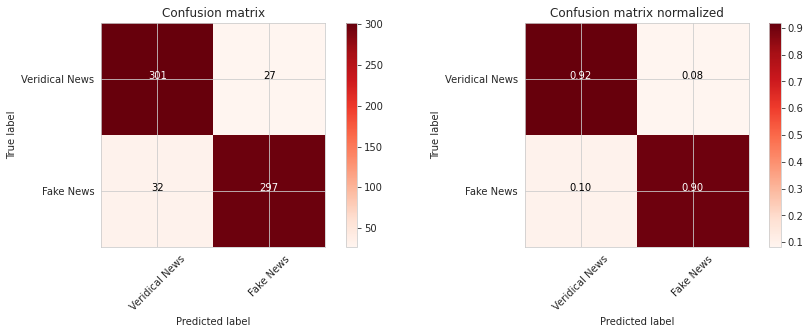

In [37]:
# display the standard and normalized confusion matrices
plt.figure(figsize=(12,8))
plt.subplot2grid(shape=(2,2), loc=(0,0))
_ = bc.plot_confusion_matrix()
plt.subplot2grid(shape=(2,2), loc=(0,1))
_ = bc.plot_confusion_matrix(normalize=True)

At this point we are also interested in finding out how well the model separates the predicted classes. If the classifier associates class probabilities that are quite similar, the model does not separate well one class from another; thus it is not reliable.

The ROC-AUC metric is a good indicator for prediction of class separability, having an ROC-AUC area of 0.95 - which is very good (the maximum possible value being 1).

We also observe that for the standard 0.5 threshold we have a true positive rate close to 0.9 and a false positive rate of close to 0.1. If we need to be more precise (avoid false positives), we could chose a threhold of 0.9 - in this case the true positive rate will drop slightly to 0.8, yet the false positive rate will be close to 0.

This makes the model to be very reliable in detecting fake news.

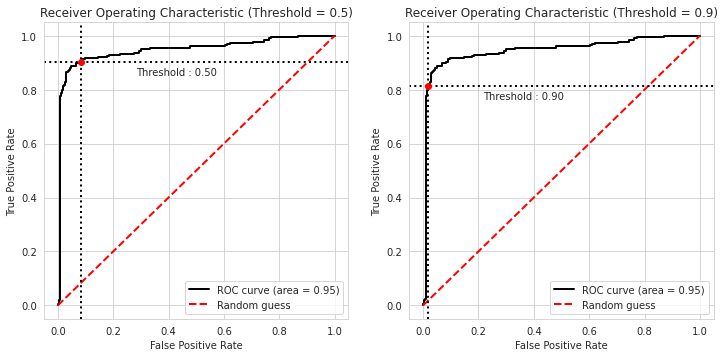

In [38]:
# display the ROC and Precision-Recall curves
plt.figure(figsize=(12,12))
plt.subplot2grid(shape=(2,2), loc=(0,0))
_ = bc.plot_roc_curve(
    threshold = 0.5,
    title= "Receiver Operating Characteristic (Threshold = 0.5)" 
  )
plt.subplot2grid(shape=(2,2), loc=(0,1))
_ = bc.plot_roc_curve(
    threshold = 0.9,
    title= "Receiver Operating Characteristic (Threshold = 0.9)" 
  )

A similar view is offered by the Precision-Recall Curve - first of all having a Precision-Recall area score of 0.95.

For a threshold of 0.5 the precision of the model have a precision of 0.8 while the the recall is around 0.9. If we choose a stricter threshold value of 0.9 we will increase the precision close to 1 while the recall drops slightly to 0.8.

This also makes the model very robust for fake news classification.

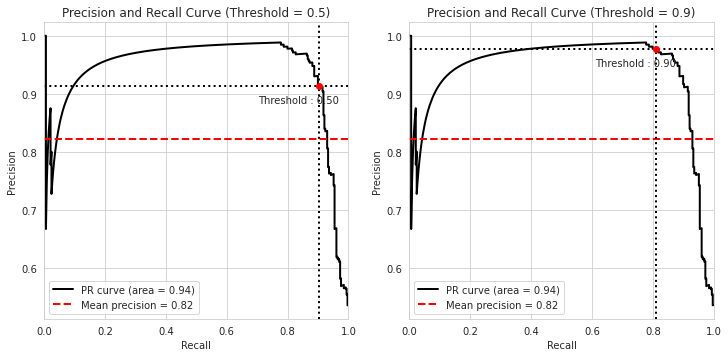

In [39]:
# display the ROC and Precision-Recall curves
plt.figure(figsize=(12,12))
plt.subplot2grid(shape=(2,2), loc=(0,0))
_ = bc.plot_precision_recall_curve(
    threshold=0.5,
    fscore_iso = None 
  )
plt.subplot2grid(shape=(2,2), loc=(0,1))
_ = bc.plot_precision_recall_curve(
    threshold=0.9,
    fscore_iso = None
  )

In conclusion, the current classifier has very good performance - having a f1 score of 0.9 and an AUC-ROC score of 0.95. Considering that we have an algorithm without any semantic capabilities and without using context data, the scores are very good.

This makes the algorithm a very good baseline choice, given its simplicity and robustness. 